In [35]:
import pandas as pd

import numpy as np

import re

In [70]:
config_prefix = ['BR', 'BI', 'TR', 'TI']

config_algo_names = ['BinarySearch', 'BubbleSort', 'Factorial', 'Fibonacci', 'IntegerBinary', 'MultiplyMatrix', 'PrimeFactors', 'ReverseString']

config_id_variable = "CASE"

config_answer_variables = [
    ['A310_01', 'A414_01', 'A214_01', 'A106_01'],
    ['BR02_01', 'BI02_01', 'TR02_01', 'TI02_01'],
    ['BR06_01', 'BI06_01', 'TR06_01', 'TI06_01'],
    ['BR10_01', 'BI10_01', 'TR10_01', 'TI10_01'],
    ['A406_01', 'A302_01', 'A102_01', 'A206_01'],
    ['A210_01', 'A114_01', 'A314_01', 'A402_01'],
    ['A110_01', 'A202_01', 'A410_01', 'A306_01'],
    ['BR14_01', 'BI14_01', 'TR14_01', 'TI14_01'],
]

config_time_variables = [
    ['TIME049','TIME070','TIME036','TIME015'],
    ['TIME021','TIME055','TIME005','TIME038'],
    ['TIME006','TIME040','TIME025','TIME061'],
    ['TIME059','TIME023','TIME042','TIME008'],
    ['TIME066','TIME051','TIME017','TIME032'],
    ['TIME034','TIME019','TIME053','TIME064'],
    ['TIME013','TIME030','TIME068','TIME047'],
    ['TIME044','TIME010','TIME057','TIME027'],
]

config_click_variables = [
    ['A319_01', 'A420_01', 'A220_01', 'A118_01'],
    ['BR18_01', 'BI18_01', 'TR18_01', 'TI18_01'],
    ['BR19_01', 'BI19_01', 'TR19_01', 'TI19_01'],
    ['BR20_01', 'BI20_01', 'TR20_01', 'TI20_01'],
    ['A418_01', 'A317_01', 'A117_01', 'A218_01'],
    ['A219_01', 'A120_01', 'A320_01', 'A417_01'],
    ['A119_01', 'A217_01', 'A419_01', 'A318_01'],
    ['BR21_01', 'BI21_01', 'TR21_01', 'TI21_01']
]


config_answer_patterns = [
    ['.*3.*', '.*3.*', '.*3.*', '.*3.*'],
    ['.*3.*16.*23.*42.*61.*75.*536.*','.*3.*16.*23.*42.*61.*75.*536.*','.*3.*16.*23.*42.*61.*75.*536.*','.*3.*16.*23.*42.*61.*75.*536.*'],
    ['.*6.*','.*6.*','.*120.*','.*120.*'],
    ['.*2.*', '.*2.*','.*2.*','.*2.*'],
    ['.*1.*0.*0.*0.*1.*','.*1.*0.*0.*0.*1.*','.*1.*0.*0.*0.*1.*','.*1.*0.*0.*0.*1.*'],
    ['.*6.*6.*6.*12.*12.*12.*18.*18.*18.*','.*6.*6.*6.*12.*12.*12.*18.*18.*18.*','.*6.*6.*6.*12.*12.*12.*18.*18.*18.*','.*6.*6.*6.*12.*12.*12.*18.*18.*18.*'],
    ['.*3.*5.*','.*3.*5.*','.*3.*5.*','.*3.*5.*'],
    ['.*gnikcar[tT].*ey[eE].*','.*gnikcar[tT].*ey[eE].*','.*gnikcar[tT].*ey[eE].*','.*gnikcar[tT].*ey[eE].*']
]


config_datasheet = r'./Book5.xlsx'

In [71]:
df_matrix = []
raw = pd.read_excel(config_datasheet)

# load data
for row, _stuff in enumerate(config_algo_names):
    df_array = []
    for col, _stuff in enumerate(config_prefix):
        df = pd.DataFrame(raw, columns = [config_id_variable, 
                                          config_answer_variables[row][col], 
                                          config_time_variables[row][col],
                                          config_click_variables[row][col],])
        df = df.iloc[1:]
        df = df.dropna()
        df_array.append(df)
    df_matrix.append(df_array)

In [72]:
cols = ["id", "response_time", "correctness", "flag", "algo_name", "click_data"]
df_BU_R = pd.DataFrame(columns=cols)
df_BU_I = pd.DataFrame(columns=cols)
df_TD_R = pd.DataFrame(columns=cols)
df_TD_I = pd.DataFrame(columns=cols)

for row_idx, df_row in enumerate(df_matrix):
    algo_name = config_algo_names[row_idx]
    for col, df in enumerate(df_row): 
        pattern = config_answer_patterns[row_idx][col]
        regex = re.compile(pattern)
        
        for index, row in df.iterrows():

            id_value =  row["CASE"]
            response_time = int(row[config_time_variables[row_idx][col]])
            answer = row[config_answer_variables[row_idx][col]]
            click_data = row[config_click_variables[row_idx][col]]
            result = regex.match(str(answer))
            correctness = False
            
            if result is not None:
                correctness = True
                
            flag = ""
            data = pd.DataFrame([[id_value, response_time, correctness, flag, algo_name, click_data]], columns=cols)
                  
            if col == 0:
                df_BU_R = df_BU_R.append(data)
            elif col == 1:
                df_BU_I = df_BU_I.append(data)
            elif col == 2:
                df_TD_R = df_TD_R.append(data)
            else:
                df_TD_I = df_TD_I.append(data)

means:[231.51572327044025, 231.475, 174.76073619631902, 241.48809523809524]
stddev:[240.02251622611962, 237.2851944854811, 204.807372141252, 371.5223736316899]
Before Outlier removal: 650


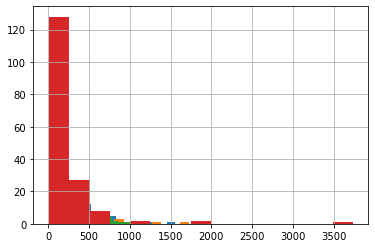

In [76]:
df_array_independent = [df_BU_R, df_BU_I, df_TD_R, df_TD_I]
df_means = [float(df[["response_time"]].mean()) for df in df_array_independent]
df_stds = [float(df[["response_time"]].std()) for df in df_array_independent]
df_len_b4 = [len(df) for df in df_array_independent]

print("means:" + str(df_means))
print("stddev:" + str(df_stds))
print("Before Outlier removal: " + str(sum(df_len_b4)))


hists = [df["response_time"].hist(bins=15) for df in df_array_independent]

<AxesSubplot:>

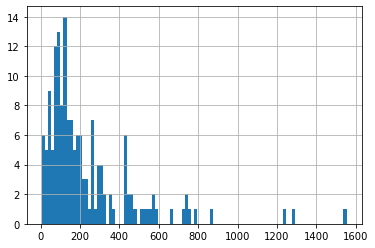

In [86]:
buckets=100
df_array_independent[0]["response_time"].hist(bins=buckets)

<AxesSubplot:>

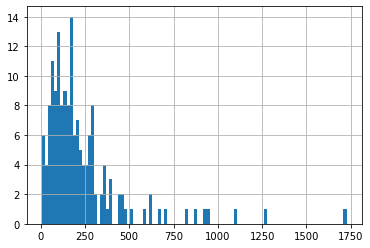

In [87]:
df_array_independent[1]["response_time"].hist(bins=buckets)

<AxesSubplot:>

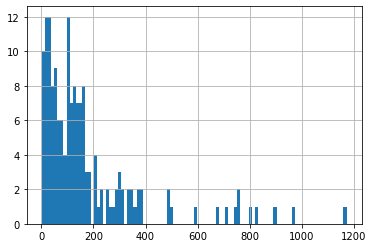

In [88]:
df_array_independent[2]["response_time"].hist(bins=buckets)

<AxesSubplot:>

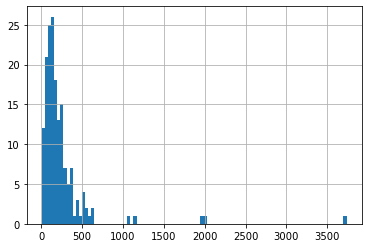

In [89]:
df_array_independent[3]["response_time"].hist(bins=buckets)

In [90]:
for idx, df in enumerate(df_array_independent):
    mean = float(df_means[idx])
    stddev = float(df_stds[idx])
    for idx, row in df.iterrows():
        response_time = row["response_time"]
        #if mean+1.5*stddev < response_time < mean+2*stddev:
        #    row["flag"] = "notNormal"
        
        #todo under 10 and wrong result
        
        #nur korrekte behandeln, ohne ausreißer
        
        #bei allen outlier raus 
        if not(10 < response_time < mean+2*stddev):
            row["flag"] = "outlier"

In [68]:
dfs_length = [len(df.loc[df["flag"]=="outlier"]) for df in df_array_independent]
print("Number of Outliers: " + str(sum(dfs_length)))

Number of Outliers: 45


In [69]:
df_means = [float(df.loc[df["flag"]!="outlier"][["response_time"]].mean()) for df in df_array_independent]
df_stds = [float(df.loc[df["flag"]!="outlier"][["response_time"]].std()) for df in df_array_independent]
df_len_after = [len(df.loc[df["flag"]!="outlier"]) for df in df_array_independent]

df_deleted_amount = [df_len_b4[idx]-df_len_after[idx] for idx in range(len(df_len_after))]
print("means without outliers: " + str(df_means))

means without outliers: [189.75675675675674, 194.35761589403972, 135.73611111111111, 189.28395061728395]


In [61]:
df_means = [float(df.loc[df["flag"]!="outlier"][["response_time"]].mean()) for df in df_array_independent]
df_stds = [float(df.loc[df["flag"]!="outlier"][["response_time"]].std()) for df in df_array_independent]
df_len_after = [len(df.loc[df["flag"]!="outlier"]) for df in df_array_independent]

In [58]:
#dfs = [df.loc[df["id"]==711] for df in df_array_independent]
#for df in dfs:
#    display(df)

In [59]:
for idx, df in enumerate(df_array_independent):
    df.loc[df["flag"] == "outlier", "response_time"] = int(df_means[idx])

In [60]:
cols = ["id", "response_time", "correctness", "flag"]
deleted = []

for idx1, df in enumerate(df_array_independent):
    for idx2, row in df.iterrows():
        id_value = row["id"]
        entries_id_BU_R = df_BU_R.loc[(df_BU_R["id"] == id_value) & (df_BU_R["flag"] == "outlier")]
        entries_id_BU_I = df_BU_I.loc[(df_BU_I["id"] == id_value) & (df_BU_I["flag"] == "outlier")] 
        entries_id_TD_R = df_TD_R.loc[(df_TD_R["id"] == id_value) & (df_TD_R["flag"] == "outlier")]
        entries_id_TD_I = df_TD_I.loc[(df_TD_I["id"] == id_value) & (df_TD_I["flag"] == "outlier")]
        
        df_per_participant = entries_id_BU_R
        df_per_participant = df_per_participant.append(entries_id_BU_I)
        df_per_participant = df_per_participant.append(entries_id_TD_R)
        df_per_participant = df_per_participant.append(entries_id_TD_I)
        
        number_of_outliers_per_participant = len(df_per_participant)
        
        if number_of_outliers_per_participant == 2:
            
            df_not_normal_id_BU_R = df_BU_R.loc[(df_BU_R["id"] == id_value) & (df_BU_R["flag"] == "notNormal")]
            df_not_normal_id_BU_I = df_BU_I.loc[(df_BU_I["id"] == id_value) & (df_BU_I["flag"] == "notNormal")] 
            df_not_normal_id_TD_R = df_TD_R.loc[(df_TD_R["id"] == id_value) & (df_TD_R["flag"] == "notNormal")]
            df_not_normal_id_TD_I = df_TD_I.loc[(df_TD_I["id"] == id_value) & (df_TD_I["flag"] == "notNormal")]
            
            number_of_not_normals = len(df_not_normal_id_BU_R) + len(df_not_normal_id_BU_I) + len(df_not_normal_id_TD_R) + len(df_not_normal_id_TD_I)
            if number_of_not_normals > 0:
                print("Participant with the following number got deleted: " + str(id_value) + ". Because 2 where missing and " + str(number_of_not_normals) + " datapoints where not normal.")
                df_BU_R = df_BU_R.loc[df_BU_R["id"]!=id_value]
                df_BU_I = df_BU_I.loc[df_BU_I["id"]!=id_value]
                df_TD_R = df_TD_R.loc[df_TD_R["id"]!=id_value]
                df_TD_I = df_TD_I.loc[df_TD_I["id"]!=id_value]
        
        elif number_of_outliers_per_participant > 2:
            print("Participant with the following number got deleted: " + str(id_value) + ". Because " + str(number_of_outliers_per_participant) + " where missing.")
            deleted.append(id_value)
            df_BU_R = df_BU_R.loc[df_BU_R["id"]!=id_value]
            df_BU_I = df_BU_I.loc[df_BU_I["id"]!=id_value]
            df_TD_R = df_TD_R.loc[df_TD_R["id"]!=id_value]
            df_TD_I = df_TD_I.loc[df_TD_I["id"]!=id_value]
            
df_array_independent = [df_BU_R, df_BU_I, df_TD_R, df_TD_I]

Participant with the following number got deleted: 712. Because 4 where missing.
Participant with the following number got deleted: 785. Because 3 where missing.


In [46]:
print(deleted)

[712, 785]


In [47]:
df_len_after2 = [len(df) for df in df_array_independent]
df_deleted_amount = [df_len_b4[idx]-df_len_after2[idx] for idx in range(len(df_len_after2))]
print("Deleted per Style: " + str(df_deleted_amount))
sum(df_len_after2)

Deleted per Style: [4, 4, 4, 4]


634

In [48]:
total_answers = [len(df) for df in df_array_independent]
total_correct = [len(df.loc[df["correctness"]==True]) for df in df_array_independent]
percentage = [float(correct)/float(total) for correct, total in zip(total_correct, total_answers)]
print("numer of total correct answers: " + str(total_correct))
print("numer of total answers: " + str(total_answers))
print("percentages of correct answers: " + str(percentage))

numer of total correct answers: [85, 93, 92, 109]
numer of total answers: [155, 156, 159, 164]
percentages of correct answers: [0.5483870967741935, 0.5961538461538461, 0.5786163522012578, 0.6646341463414634]


In [49]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
cols = ["Subject","ProgrammingStyle", "Comprehension", "ResponseTime", "Algorithm", "Flag", "Correctness", "ClickData"]

def fill(list_data, dataframe, coding_style, comprehension_style):
    for idx, row in dataframe.iterrows():
        response_time = row["response_time"]
        algorithm = row["algo_name"]
        flag = row["flag"]
        click_data = row["click_data"]
        correctness = row["correctness"]
        id = row["id"]
        list_data.append([id,coding_style, comprehension_style, response_time, algorithm, flag, correctness, click_data])

data = []
fill(data, df_BU_R, "R", "BU")
fill(data, df_BU_I, "I", "BU")
fill(data, df_TD_R, "R", "TD")
fill(data, df_TD_I, "I", "TD")
df = pd.DataFrame(data, columns=cols)
df.to_excel("preprocessed.xlsx", index=False)

In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("ResponseTime ~ C(ProgrammingStyle) * C(Comprehension) * C(ProgrammingStyle):C(Comprehension)", data=df.loc[df["Flag"]!="outlier"]).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(ProgrammingStyle),1.278280e+05,1.0,7.792881,0.005411
C(Comprehension),1.248239e+05,1.0,7.609738,0.005981
C(ProgrammingStyle):C(Comprehension),9.606846e+04,1.0,5.856696,0.015811
Residual,9.923926e+06,605.0,NaN,NaN


In [107]:
from scipy.stats import chisquare

df_BU_R
df_BU_I
df_TD_R
df_TD_I

chisquare([len(df_BU_R.loc[df_BU_R["correctness"]] == True)/len(df_BU_R),
           len(df_BU_I.loc[df_BU_I["correctness"]] == True)/len(df_BU_I),
           len(df_TD_R.loc[df_TD_R["correctness"]] == True)/len(df_TD_R),
           len(df_TD_I.loc[df_TD_I["correctness"]] == True)/len(df_TD_I)])



Power_divergenceResult(statistic=0.011294972754284375, pvalue=0.915361937459655)

In [101]:
len(df_BU_R.loc[df_BU_R["correctness"]] == True)/len(df_BU_R)

0.5471698113207547

In [99]:
len(df_BU_I.loc[df_BU_I["correctness"]] == True)/len(df_BU_I)

0.6

In [100]:
len(df_TD_R.loc[df_TD_R["correctness"]] == True)/len(df_TD_R)

0.5828220858895705

In [102]:
len(df_TD_I.loc[df_TD_I["correctness"]] == True)/len(df_TD_I)

0.6607142857142857